## SG Census 
Jupyter Notebook for preparation and cleaning of data

Final anticipated output (Data): 
- Census Data (pandas df)
- Mapping Data (geopandas gdf)

In [37]:
# Import libraries

#System
import requests

# Data Manipulation
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
from bs4 import BeautifulSoup

# Data Visualization
import matplotlib.pyplot as plt
import geopandas as gpd


### Loading Census Data 
Resident Population by Planning Area/Subzone of Residence, Ethnic Group and Sex (Census of Population 2020)

In [38]:
# OpenAPI query from data.gov.sg

# Dataset ID
dataset_id = "d_e7ae90176a68945837ad67892b898466"
base_url = "https://data.gov.sg/api/action/datastore_search"

# Pagination setup
limit = 1000  # max limit per request
offset = 0
all_records = []

# Request response
while True:
    url = f"{base_url}?resource_id={dataset_id}&limit={limit}&offset={offset}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        records = data['result']['records']
        
        if not records:
            break  # No more data - end 

        all_records.extend(records)
        print(f"Fetched {len(all_records)} records so far...")

        offset += limit
    else:
        print("Error:", response.status_code)
        break

# Export to DataFrame
df = pd.DataFrame(all_records)
print(f"\n✅ Total records fetched: {len(df)}")


Fetched 388 records so far...

✅ Total records fetched: 388


In [39]:
#Dataframe 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   _id              388 non-null    int64 
 1   Number           388 non-null    object
 2   Total_Total      388 non-null    object
 3   Total_Males      388 non-null    object
 4   Total_Females    388 non-null    object
 5   Chinese_Total    388 non-null    object
 6   Chinese_Males    388 non-null    object
 7   Chinese_Females  388 non-null    object
 8   Malays_Total     388 non-null    object
 9   Malays_Males     388 non-null    object
 10  Malays_Females   388 non-null    object
 11  Indians_Total    388 non-null    object
 12  Indians_Males    388 non-null    object
 13  Indians_Females  388 non-null    object
 14  Others_Total     388 non-null    object
 15  Others_Males     388 non-null    object
 16  Others_Females   388 non-null    object
dtypes: int64(1), object(16)
memory usag

In [40]:
df.head(5)

,_id,Number,Total_Total,Total_Males,Total_Females,Chinese_Total,Chinese_Males,Chinese_Females,Malays_Total,Malays_Males,Malays_Females,Indians_Total,Indians_Males,Indians_Females,Others_Total,Others_Males,Others_Females
0,1,Total,4044210,1977560,2066650,3006770,1461340,1545430,545500,271330,274170,362270,185570,176710,129670,59320,70350
1,2,Ang Mo Kio - Total,162280,77570,84700,134350,64050,70300,11140,5480,5660,12810,6350,6470,3970,1690,2280
2,3,Ang Mo Kio Town Centre,4810,2260,2550,4140,1950,2200,140,60,80,370,170,200,160,80,80
3,4,Cheng San,28070,13480,14600,23240,11120,12120,1940,960,980,2280,1150,1130,610,250,370
4,5,Chong Boon,26500,12860,13640,21860,10590,11270,1830,920,900,2240,1130,1110,580,220,360


Data preparation steps required:

- Drop records which contain additions of subzones E.g. "Ang Mo Kio - Total' to new df copy as these indicate rounding up of subzone population for each district
- Make Uppercase for Subzone string 
- General Change of Object Dtype to INT64
- Rename columns

In [41]:
# Boolean indexing to drop rows with 'Total' 
mask = df['Number'].str.contains('Total', na=False)

# Select all rows except masked
df = df[~mask]

#Print check
print(f"\n✅ Total records after dropping 'Total': {len(df)}")


✅ Total records after dropping 'Total': 332


In [42]:
# Rename columns 
df.rename(columns={
    '_id': 'ID',
    'Number': 'Subzone',
    'Total_Total': 'Subzone Total',
    'Total_Males': 'Total Males',
    'Total_Females': 'Total Females',
    'Chinese_Total': 'Total Chinese',
    'Chinese_Males': 'Chinese Males',
    'Chinese_Females': 'Chinese Females',
    'Malays_Total': 'Total Malays',
    'Malays_Males': 'Malay Males',
    'Malays_Females': 'Malay Females',
    'Indians_Total': 'Total Indians',
    'Indians_Males': 'Indian Males',
    'Indians_Females': 'Indian Females',
    'Others_Total': 'Total Others',
    'Others_Males': 'Others Male',
    'Others_Female': 'Others Females'
}, inplace=True)

# Clean invalid entries (e.g., '-') and convert all except Subzone to int64
df.replace(['-',0], pd.NA, inplace=True)
df = df.astype({col: 'object' if col == 'Subzone' else 'Int64' for col in df.columns})

# Convert string values in Subzone to uppercase
df['Subzone'] = df['Subzone'].str.upper()



Export cleaned data in csv for Python Script

*Note that there is a simple imputation value of 10 for records with 0 (some subzones like Central Water Catchment have no resident population) to allow for map gradient scaling

In [43]:
# Reset the index
df.reset_index(drop=True, inplace=True)

# Fill all missing values (0) with 10 
df = df.fillna(10)

# Export to CSV 
df.to_csv('./data/census_cleaned.csv', index=False)
print("\n✅ Data exported")


✅ Data exported


#### Loading Geospatial Data
Master Plan 2019 Subzone Boundary (No Sea) (GEOJSON)

In [44]:
# Dataset ID and poll-download URL
dataset_id = "d_8594ae9ff96d0c708bc2af633048edfb"
base_url = f"https://api-open.data.gov.sg/v1/public/api/datasets/{dataset_id}/poll-download"

# Step 1: Get the actual download URL from poll-download
response = requests.get(base_url)
json_data = response.json()

if json_data['code'] != 0:
    print(json_data['errMsg'])
    exit(1)

download_url = json_data['data']['url']

# Step 2: Download GEOJSON
geo_response = requests.get(download_url)
geojson = geo_response.json()

# Step 3: Extract and flatten features
features = geojson.get("features", [])

# Prepare records and geometries
records = []
geometries = []

for feature in features:
    properties = feature.get("properties", {})
    geometry = feature.get("geometry", {})
    
    records.append(properties)
    geometries.append(shape(geometry))  # Convert to shapely geometry

# Step 4: Create Pandas DataFrame (attributes only)
df_attributes = pd.DataFrame(records)
print(f"✅ Attribute DataFrame created: {len(df_attributes)} rows")

# Step 5: Create GeoDataFrame (attributes + geometry)
gdf = gpd.GeoDataFrame(df_attributes, geometry=geometries)
print(f"✅ GeoDataFrame created: {len(gdf)} features")


✅ Attribute DataFrame created: 332 rows
✅ GeoDataFrame created: 332 features


gdf Dataframe contains 3 columns, of which the variables such as the subzone names are in a HTML table

In [45]:
gdf.head(5)

,Name,Description,geometry
0,kml_1,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.81454 1.28239 0, 103.81774 1.2..."
1,kml_2,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.82209 1.28049 0, 103.8221 1.28..."
2,kml_3,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.84375 1.28508 0, 103.844 1.284..."
3,kml_4,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.84962 1.28412 0, 103.84955 1.2..."
4,kml_5,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.85253 1.28617 0, 103.85253 1.2..."


Parsing of HTML in 'Description' attribute through BeautifulSoup Library

In [46]:
# Extract data
records = []
geometries = []

#BeautifulSoup to parse HTML content
for feature in features:
    props = feature["properties"]
    description_html = props["Description"]
    soup = BeautifulSoup(description_html, "html.parser")
    
    record = {}
    rows = soup.find_all("tr")
    for row in rows:
        headers = row.find_all("th")
        cols = row.find_all("td")
        if len(headers) == 1 and len(cols) == 1:
            key = headers[0].text.strip()
            val = cols[0].text.strip()
            record[key] = val
    
    # Append the parsed geometry using shapely
    geom = shape(feature["geometry"])
    geometries.append(geom)
    records.append(record)

In [47]:
# Create GeoDataFrame
gdf = gpd.GeoDataFrame(records, geometry=geometries)

# Print info
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   SUBZONE_NO  332 non-null    object  
 1   SUBZONE_N   332 non-null    object  
 2   SUBZONE_C   332 non-null    object  
 3   CA_IND      332 non-null    object  
 4   PLN_AREA_N  332 non-null    object  
 5   PLN_AREA_C  332 non-null    object  
 6   REGION_N    332 non-null    object  
 7   REGION_C    332 non-null    object  
 8   INC_CRC     332 non-null    object  
 9   FMEL_UPD_D  332 non-null    object  
 10  geometry    332 non-null    geometry
dtypes: geometry(1), object(10)
memory usage: 28.7+ KB


In [48]:
gdf.head(3)

,SUBZONE_NO,SUBZONE_N,SUBZONE_C,CA_IND,PLN_AREA_N,PLN_AREA_C,REGION_N,REGION_C,INC_CRC,FMEL_UPD_D,geometry
0,12,DEPOT ROAD,BMSZ12,N,BUKIT MERAH,BM,CENTRAL REGION,CR,C22DED671DE2A940,20191223152313,"POLYGON Z ((103.81454 1.28239 0, 103.81774 1.2..."
1,2,BUKIT MERAH,BMSZ02,N,BUKIT MERAH,BM,CENTRAL REGION,CR,085EF219A5A1AEAD,20191223152313,"POLYGON Z ((103.82209 1.28049 0, 103.8221 1.28..."
2,3,CHINATOWN,OTSZ03,Y,OUTRAM,OT,CENTRAL REGION,CR,EF2B9A91AF49E025,20191223152313,"POLYGON Z ((103.84375 1.28508 0, 103.844 1.284..."


Data preparation steps required:

- Drop non-essential metadata columns 
- Rename columns

In [49]:
#Drop non-essential columns 
gdf.drop(columns=['SUBZONE_C', 'CA_IND', 'PLN_AREA_C', 'REGION_C', 'INC_CRC', 'FMEL_UPD_D'], inplace=True)

#Rename columns
#Note 'geomtery' cannot be renamed as it is a special column in GeoDataFrame
gdf.rename(columns={
    'SUBZONE_NO': 'Subzone Code',
    'SUBZONE_N': 'Subzone',
    'PLN_AREA_N': 'Planning Area',
    'REGION_N': 'Region',
}, inplace=True)

gdf.head(3)


,Subzone Code,Subzone,Planning Area,Region,geometry
0,12,DEPOT ROAD,BUKIT MERAH,CENTRAL REGION,"POLYGON Z ((103.81454 1.28239 0, 103.81774 1.2..."
1,2,BUKIT MERAH,BUKIT MERAH,CENTRAL REGION,"POLYGON Z ((103.82209 1.28049 0, 103.8221 1.28..."
2,3,CHINATOWN,OUTRAM,CENTRAL REGION,"POLYGON Z ((103.84375 1.28508 0, 103.844 1.284..."


In [50]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Subzone Code   332 non-null    object  
 1   Subzone        332 non-null    object  
 2   Planning Area  332 non-null    object  
 3   Region         332 non-null    object  
 4   geometry       332 non-null    geometry
dtypes: geometry(1), object(4)
memory usage: 13.1+ KB


In [51]:
# Reset the index
gdf.reset_index(drop=True, inplace=True)

# Export to CSV 
gdf.to_file('./data/gdf_cleaned.geojson', driver='GeoJSON')
print("\n✅ GeoDataFrame exported")

c:\Users\Xun An\.conda\envs\jupyterlab\Lib\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(



✅ GeoDataFrame exported


gdf testing

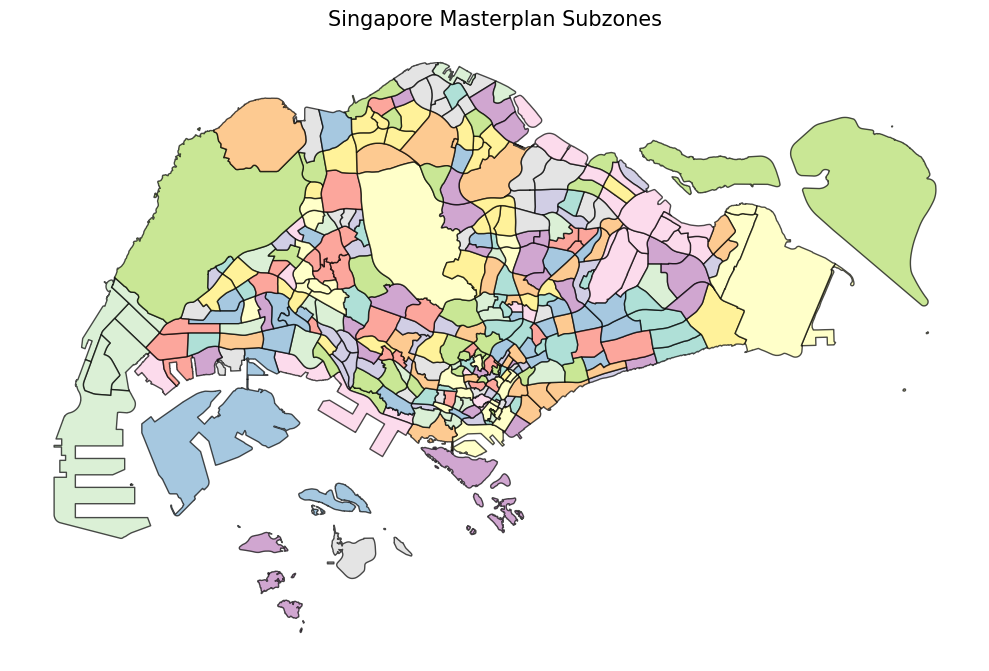

In [52]:
# TestPlot all subzones
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, edgecolor='black', column='Subzone', legend=False, cmap='Set3', alpha=0.7)
plt.title("Singapore Masterplan Subzones", fontsize=15)
plt.axis('off')
plt.tight_layout()
plt.show()

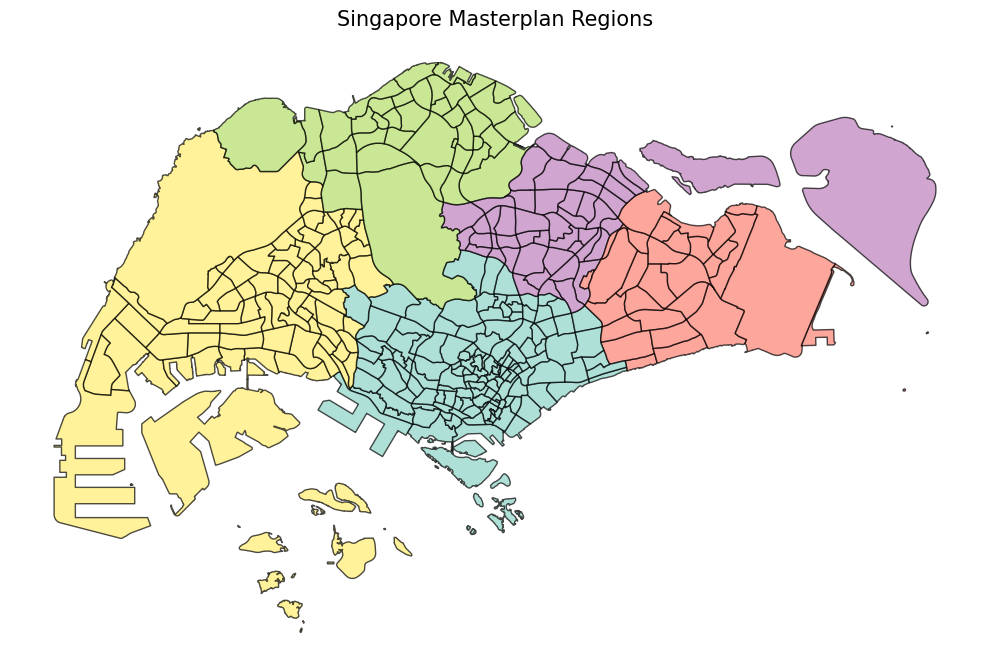

In [53]:
# TestPlot all regions
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, edgecolor='black', column='Region', legend=False, cmap='Set3', alpha=0.7)
plt.title("Singapore Masterplan Regions", fontsize=15)
plt.axis('off')
plt.tight_layout()
plt.show()